In [1]:
%%capture

!pip install -r requirements.txt

In [126]:
import pandas as pd
import numpy as np
import unicodedata
import re
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import fasttext
from sklearn.cluster import KMeans
from wordcloud import WordCloud
from sklearn.metrics import silhouette_score

In [108]:
df = pd.read_csv('Balanced_AHR.csv')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7615 entries, 0 to 7614
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   7615 non-null   int64 
 1   title        7615 non-null   object
 2   rating       7615 non-null   int64 
 3   review_text  7615 non-null   object
 4   location     6819 non-null   object
 5   hotel        6819 non-null   object
 6   label        7615 non-null   int64 
dtypes: int64(3), object(4)
memory usage: 416.6+ KB


In [10]:
df.sample(5)

,Unnamed: 0,title,rating,review_text,location,hotel,label
2167,2167,Fin de semana,1,Mal servicio mala limpieza y trabajadores con ...,Granada_Province_of_Granada_Andalucia,Hotel_Los_Angeles_Spa,0
596,596,"Mal, poco colaboradores.",1,No puedo opinar sobre este hotel porque no lle...,Seville_Province_of_Seville_Andalucia,Hostel_One_Sevilla_Centro,0
2409,2409,Hotel sin nada especial,3,Hotel normal sin nada especial. Me recordaba a...,Cordoba_Province_of_Cordoba_Andalucia,Hotel_Oasis_de_Cordoba,3
643,643,Hostal centrico,3,"El hostal se encuentra en el centro, la habita...",Seville_Province_of_Seville_Andalucia,La_Flamenka_Hostel,3
5988,5988,Hotel moderno y con mucho gusto,5,Un hotelito muy bien situado y reformado con m...,Seville_Province_of_Seville_Andalucia,Hotel_La_Parada_del_Marques,1


In [106]:
df.describe()

,title,review_text,text
count,7615,7615,7615
unique,4325,5101,5101
top,Excelente,No se puede criticar la ubicación dada el host...,Excelente ubicación. No se puede criticar la u...
freq,78,12,12


In [109]:
df = df[df['rating'] >= 4]      # Solo reseñas positivas

In [110]:
# Eliminar columnas innecesarias
df = df.drop(['label', 'hotel', 'location', 'rating', 'Unnamed: 0'], axis=1)

In [111]:
# Crear una columna que combine title y review
df['text'] = df['title'].astype(str)+'. '+df['review_text'].astype(str)

In [112]:
# Crear lista con cada oración (separada por .) por separado
lista_text = df['text'].tolist()

sentences = []

for line in lista_text:
    line = line.rstrip()
    oraciones = line.split('.')
    for oracion in oraciones:
        oracion = oracion.lstrip(' ')
        sentences.append(oracion)
sentences = list(filter(None, sentences))

In [113]:
# Convertir la lista anterior a dataframe
df_sentences = pd.DataFrame (sentences, columns = ['text'])

In [114]:
# Limpieza del texto
def preprocesar_columna(df):
    df['text'] = df['text'].str.strip().str.lower()
    caracteres = ['!', ',', '&', ':', ';', '(', ')', '.', '?', '"']
    for car in caracteres:
        df['text'] = df['text'].str.replace(car,'', regex=False)
    df['text'] = df['text'].str.normalize('NFKC')
    df['text'] = df['text'].str.replace(r'([a-zA-Z])\1{2,}', r'\1', regex=True) 
    return df

In [115]:
df_sentences = preprocesar_columna(df_sentences)

In [116]:
def normalize_str(text_string):
    if text_string is not None:
        result = unicodedata.normalize('NFD', text_string).encode('ascii', 'ignore').decode()
    else:
        result = None
    return result

In [117]:
df_sentences['text'] = df_sentences['text'].apply(normalize_str)

In [ ]:
# Por ahora no elimino las stopwords. Hacerlo después de clusterizar, antes de hacer las wordclouds

In [118]:
tfile = open('positivo.txt', 'a')
tfile.write(df_sentences.to_string())
tfile.close()

In [119]:
model = fasttext.train_unsupervised('positivo.txt')

Read 1M words
Number of words:  10230
Number of labels: 0
Progress: 100.0% words/sec/thread:   60794 lr:  0.000000 avg.loss:  2.276733 ETA:   0h 0m 0s


In [120]:
df_sentences['vec'] = df_sentences['text'].apply(lambda x: model.get_sentence_vector(x))

In [121]:
df_sentences.sample(5)

,text,vec
10195,el desayuno tipo buffet genial con buenos prod...,"[0.02494485, 0.14009586, -0.07169419, -0.03020..."
2252,gracias a todo el personal por su buen hacer,"[0.015075882, 0.18242292, -0.066688396, -0.061..."
10680,es un viaje en el tiempo a la sevilla antigua,"[0.02436633, 0.22681549, -0.050930023, -0.0691..."
12418,espectacular nuevo hotel en el casco antiguo,"[-0.00871408, 0.21270593, 0.03412857, -0.09229..."
13917,situacion privilegiada limpieza y precio adecu...,"[0.056333773, 0.17159006, -0.051184405, -0.057..."


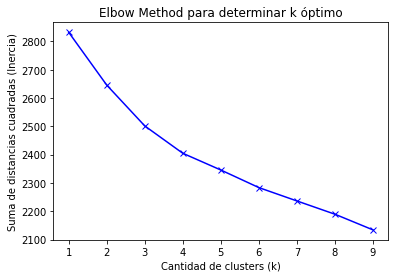

In [122]:
sum_distancias_cuadradas = []

K = range(1,10)
for num_clusters in K :
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_sentences['vec'].values.tolist())
    sum_distancias_cuadradas.append(kmeans.inertia_)

plt.plot(K, sum_distancias_cuadradas, 'bx-')
plt.xlabel('Cantidad de clusters (k)')
plt.ylabel('Suma de distancias cuadradas (Inercia)')
plt.title('Elbow Method para determinar k óptimo')
plt.show()

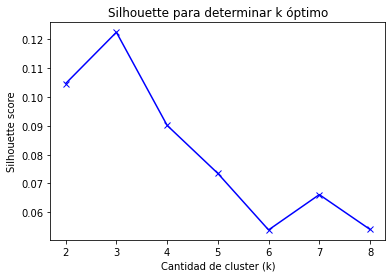

In [128]:
# Método para determinar la cantidad óptima de clusters

rango_n_clusters = [2, 3, 4, 5, 6, 7, 8]
silhouette_avg = []

for num_clusters in rango_n_clusters:

    # fit Kmeans
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans.fit(df_sentences['vec'].values.tolist())
    cluster_labels = kmeans.labels_

    # calcular silhouette
    silhouette_avg.append(silhouette_score(df_sentences['vec'].values.tolist(), cluster_labels))

plt.plot(rango_n_clusters, silhouette_avg, 'bx-')    
plt.xlabel('Cantidad de cluster (k)')
plt.ylabel('Silhouette score')
plt.title('Silhouette para determinar k óptimo')
plt.show()

In [129]:
kmeans = KMeans(n_clusters=3)

In [130]:
df_sentences['cluster'] = kmeans.fit_predict(df_sentences['vec'].values.tolist())

In [131]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [132]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/gitpod/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [133]:
def eliminar_stopwords(text_string):
    stop_words = set(stopwords.words('spanish'))
    word_tokens = word_tokenize(text_string)
    filtered_sentence = [w for w in word_tokens if not w in stop_words]
    sentence = ' '.join(str(x) for x in filtered_sentence)
    return sentence

In [134]:
df_sentences['text_sin_stopwords'] = df_sentences['text'].apply(eliminar_stopwords)

In [135]:
cluster_0 = df_sentences[df_sentences['cluster']==0]
cluster_1 = df_sentences[df_sentences['cluster']==1]
cluster_2 = df_sentences[df_sentences['cluster']==2]

In [136]:
def generate_wordcloud(df):
    text = ' '.join([i for i in df['text_sin_stopwords']])
    wordcloud = WordCloud(max_words=100, background_color='Black').generate(text)
    plt.figure(figsize=(12,12))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.show()

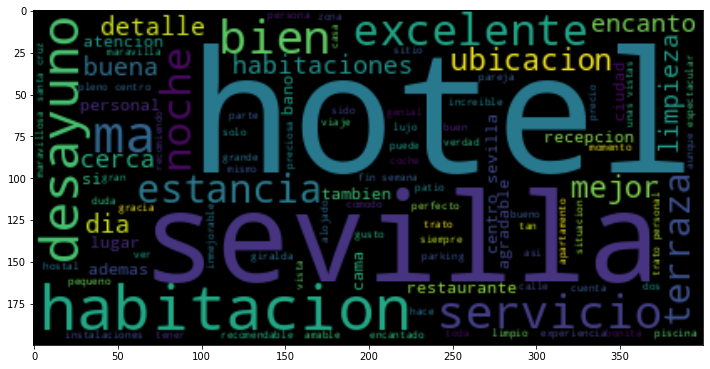

In [137]:
generate_wordcloud(cluster_0)

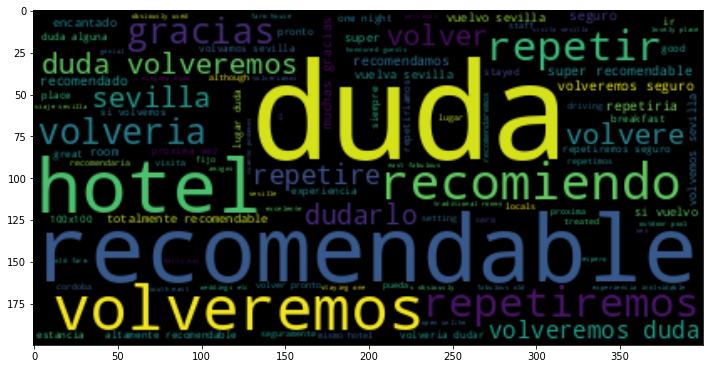

In [138]:
generate_wordcloud(cluster_1)

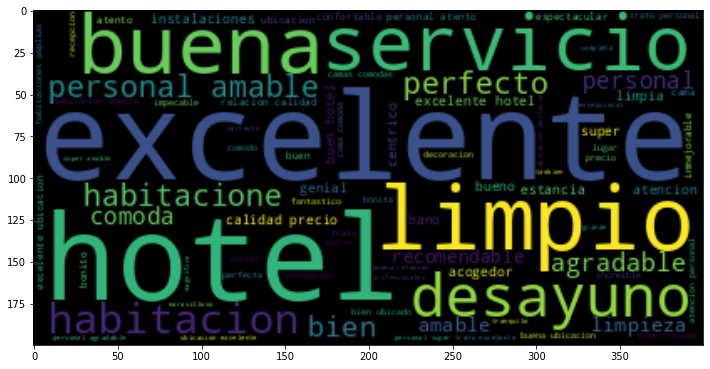

In [141]:
generate_wordcloud(cluster_2)

In [140]:
print(len(cluster_0))
print(len(cluster_1))
print(len(cluster_2))

9444
1220
4212
